In [1]:
#!/usr/bin/env python3

from smodels.base import runtime
from smodels.base.physicsUnits import TeV
from smodels.matching.theoryPrediction import theoryPredictionsFor,TheoryPredictionsCombiner
from smodels.tools import coverage
from smodels.base.crossSection import getXsecFromSLHAFile,XSection,XSectionList
from smodels.base.smodelsLogging import setLogLevel
from smodels.tools.particlesLoader import load
from smodels.share.models.SMparticles import SMList
from smodels.base.model import Model
from smodels.base.genericSMS import GenericGraph
from smodels.decomposition.decomposer import getDecayNodes
from smodels.base.particleNode import ParticleNode
import itertools

import pyslha
import time
setLogLevel("error")

In [2]:
#slhafile = 'inputFiles/slha/TRVS1_1800_300_300.slha'
#slhafile = 'inputFiles/slha/TRV1_1800_300_300.slha'
slhafile = 'inputFiles/slha/TN1N1_tchannel.slha'

In [3]:
# Load the BSM model
runtime.modelFile = slhafile
BSMList = load()
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)

In [4]:
print(model)

Model: inputFiles/slha/TN1N1_tchannel.slha


### List Cross-Sections

In [5]:
for xsec in model.xsections:
    print(xsec.full_pid)

(2212, 2212, 1000022, 1000022)


### List Decays

In [6]:
for mom in model.BSMparticles:
    momNode = ParticleNode(mom)
    decayNodesList = getDecayNodes(momNode)
    if not decayNodesList:
        continue
    print(decayNodesList)

[(dl, [n1, q], 1.0)]
[(dl~, [n1, q], 1.0)]


In [7]:
def normSelfConj(model,part_list):
    output_list=[]
    for part in part_list:
        if part.pdg in {-21,-22,-23,-25}:
            output_list.append(part.chargeConjugate())
        elif any(p == -part.pdg for p in itertools.chain(*model.getSMandBSMList())):
            output_list.append(part)
        else:
            output_list.append(part)
    return output_list

def normSelfConj_pdg(model,part_list):
    output_list=[]
    for part in part_list:
        if part in {-21,-22,-23,-25}:
            output_list.append(-part)
        elif any(p == -part for p in itertools.chain(*model.getSMandBSMList())):
            output_list.append(part)
        elif part<0:
            output_list.append(-part)
        else:
            output_list.append(part)
    return output_list

def simpleConj(model, part):
    if part.pdg in {21,22,23,25}:
        return part
    elif part.pdg in {-21,-22,-23,-25}:
        return part.chargeConjugate()
    elif any(p == -part.pdg for p in itertools.chain(*model.getSMandBSMList())):
        return part.chargeConjugate()
    return part

def simpleConj_pdg(model, part_pdg):
    '''
    Receives a model class and the pdg number of a particle, and returns the pdg corresponding to its conjugate. In the case where it is self-conjugate, instead it returns abs(part_pdg). The verification of selfconjugation relies on a conjugate with (conjugate_pdg = -part_pdg) not existing in the model among the BSMParticles. SM states are filtered separately due to subtleties in implementation.

    :return: an int containing the pdg of the conjugate particle
    '''
    if abs(part_pdg) in {21,22,23,25}:
        return abs(part_pdg)
    elif any(p == -part_pdg for p in itertools.chain(*model.getSMandBSMList())):
        return -part_pdg
    return part_pdg

def fstToist(vertex, part, model):
    ist = vertex['ist'].copy()
    fst = vertex['fst'].copy()
    try:
        fst.remove(part)
        #print("Part removed from final state: ",part)
        ist_part = simpleConj_pdg(model, part)
        #print("Particle to be added to the initial state: ",ist_part)
    except:
        # logger.error("Final state does not contain the specified particle.")
        print("Final state: ",fst)
        return
    ist.append(ist_part)
    return {'ist':ist,'fst':fst}

def istTofst(vertex,part, model):
    ist = vertex['ist'].copy()
    fst = vertex['fst'].copy()
    try:
        ist.remove(part)
    except:
        # logger.error("Final state does not contain the specified particle.")
        print("Initial state: ",ist)
    fst.append(simpleConj_pdg(model, part))
    return {'ist':ist,'fst':fst}

In [8]:
def order_states(ptc,model):
    part = model.getSingleParticle(pdg=ptc)
    return not part.isSM, abs(part.pdg)

def conj_diagram_tuples(model,tuples_diag):
     return tuple([simpleConj_pdg(model,el) for el in tuples_diag])

def generate_vertices(model):
    decays = []
    for ptc in model.BSMparticles:
        decaylist = ptc.decays
        for decay in decaylist:
            decays.append([ptc.pdg,decay.ids])
    
    decay_vertices=[]
    for decay in decays:
        decay_vertices.append({'ist':normSelfConj_pdg(model,[decay[0]]),'fst':normSelfConj_pdg(model,decay[1])})
    
    vertices = {}
    for vert in decay_vertices:
        while vert['ist']:
            ptc = vert['ist'][0]
            vert = istTofst(vert,ptc,model)
        for part in vert['fst']:
                #vertices.append(fstToist(vert,part,model))
                #vertices[-1]['fst'].sort(key=lambda p: order_states(p,model),reverse=True)
                aux=fstToist(vert,part,model)
                aux['fst'].sort(key=lambda p: order_states(p,model),reverse=True)
                vertices[part,tuple(aux['fst'])]=aux.copy()

    return vertices

In [9]:
allvertices = generate_vertices(model)

In [10]:
allvertices

{(1000022, (-1000001, 1)): {'ist': [1000022], 'fst': [-1000001, 1]},
 (1, (1000022, -1000001)): {'ist': [-1], 'fst': [1000022, -1000001]},
 (-1000001, (1000022, 1)): {'ist': [1000001], 'fst': [1000022, 1]},
 (1000022, (1000001, -1)): {'ist': [1000022], 'fst': [1000001, -1]},
 (-1, (1000022, 1000001)): {'ist': [1], 'fst': [1000022, 1000001]},
 (1000001, (1000022, -1)): {'ist': [-1000001], 'fst': [1000022, -1]}}

In [11]:
for vert in allvertices.values():
    print(vert)

{'ist': [1000022], 'fst': [-1000001, 1]}
{'ist': [-1], 'fst': [1000022, -1000001]}
{'ist': [1000001], 'fst': [1000022, 1]}
{'ist': [1000022], 'fst': [1000001, -1]}
{'ist': [1], 'fst': [1000022, 1000001]}
{'ist': [-1000001], 'fst': [1000022, -1]}


In [12]:
def build_quark_ists(model,vert_list):
    ists = []
    for vert in vert_list.values():
        #print(vert['fst'])
        if vert['fst'] in tuple([q1,q2] for q1 in range(-3,4) for q2 in range(-3,4)):
            #Commented should be the final form of this code, after parsing through the vertex listings
            #two_to_one[tuple(vert['fst'])] = {'ist':vert['ist'].copy(),'fst':vert['fst'].copy()}
            #Below is a temporary implementation, assuming all vertices are triples, and u,d,s quark decays
            #two_to_one.append({'ist':{'ist':vert['fst'].copy(),'fst':vert['ist'].copy()},'fst':{'fst':vert['ist'].copy()}})
            ists.append({'ist':vert['fst'].copy(),'fst':vert['ist'].copy()})
    return ists

def build_proton_ists(model,vert_list):
    ists = []
    #temp definition of the proton particle content, change for something in a wider scope in future implementation
    proton = [1,-1,2,-2,3,-3,21]
    for vert in vert_list.values():
        if vert['fst'] in tuple([q1,q2] for q1 in proton for q2 in proton):
            ist_aux = vert['ist']
            fst_aux = vert['fst']
            vert_aux = {'ist':ist_aux.copy(),'fst':fst_aux.copy()}
            #^Very crude implementation for now to guarantee functionality and no cross-references, will refine later
            for ptc in ist_aux:
                vert_aux = istTofst(vert_aux,ptc,model)
            for ptc in fst_aux:
                vert_aux = fstToist(vert_aux,ptc,model)
            ists.append({'ist':vert_aux['ist'].copy(),'fst':vert_aux['fst'].copy()})
    return ists

def build_mixed_ists(model,vert_list):
    ists = []
    #temp definition of the proton particle content, change for something in a wider scope in future implementation
    proton = [1,-1,2,-2,3,-3,21]
    for vert in vert_list.values():
        if any(vert['ist'][0] == p.pdg for p in model.BSMparticles):
            for ptc in vert['fst']:
                if any(ptc == p for p in proton):
                    conj_vert = fstToist(vert,ptc,model)
                    ists.append({'ist':sorted(conj_vert['ist'],key=lambda p: order_states(p,model),reverse=True),'fst':sorted(conj_vert['fst'],key=lambda p: order_states(p,model),reverse=True)})
                    #ists.append({'ist':conj_vert['fst'],'fst':conj_vert['ist']})
    return ists


def build_2to1(model,vert_list):
    diagrams = {}
    ists = build_proton_ists(model,vert_list)
    for ist in ists:
        diagrams[tuple(ist['ist']),tuple(ist['fst']),None,tuple(ist['fst'])]=({'ist':ist,'fst':{'fst':ist['fst']}})
    return diagrams


def build_2to2(model, vert_list):
    schannel = {}
    tchannel = {}
    outtchannel={}
    singtchannel={}
    duplicatetchannel={}
    halfchannel = build_proton_ists(model,vert_list)
    for instates in halfchannel:
        for vert in vert_list.values():
            if vert['ist']==instates['fst']:
                #schannel.append({'ist':instates, 'fst':vert})
                schannel[tuple(instates['ist']),tuple(instates['fst']),tuple(vert['ist']),tuple(vert['fst'])]={'ist':instates, 'fst':vert.copy()}

    halfchannel = build_mixed_ists(model,vert_list)
    for instates in halfchannel:
        for vert in vert_list.values():
            if vert['ist']==instates['fst']:
                #tchannel.append({'ist':instates, 'fst':vert})
                tchannel[tuple(instates['ist']),tuple(instates['fst']),tuple(vert['ist']),tuple(vert['fst'])]={'ist':instates, 'fst':vert.copy()}      

    for key,diagram in tchannel.items():
        newkey = tuple([tuple([simpleConj_pdg(model,key[i][j]) if (i,j) in {(0,0),(2,0),(len(key)-1,len(key[i])-1)}else key[i][j] for j in range(len(key[i]))]) for i in range(len(key))])
        outtchannel[newkey] = diagram

    for key in outtchannel.keys():
        conj_key = tuple(reversed(key))
        if conj_key not in outtchannel or key == conj_key:
            singtchannel[key] = outtchannel[key]
        elif conj_key not in duplicatetchannel:
            singtchannel[key] = outtchannel[key]
            duplicatetchannel[key] = outtchannel[key]
        else:
            duplicatetchannel[key] = outtchannel[key]

    return schannel,singtchannel

In [13]:
testeists = build_proton_ists(model,allvertices)
print(testeists)

[]


In [14]:
tto = build_2to1(model,allvertices)
ttt_s,ttt_t = build_2to2(model,allvertices)
print('2-to-1 processes: \n',tto,'\n')
print('s-channel 2-to-2 processes: \n',ttt_s,'\n')
print('t-channel 2-to-2 processes: \n', ttt_t)

2-to-1 processes: 
 {} 

s-channel 2-to-2 processes: 
 {} 

t-channel 2-to-2 processes: 
 {((1000022, -1), (-1000001,), (1000001,), (1000022, 1)): {'ist': {'ist': [1000022, -1], 'fst': [-1000001]}, 'fst': {'ist': [-1000001], 'fst': [1000022, -1]}}, ((-1000001, -1), (1000022,), (1000022,), (-1000001, -1)): {'ist': {'ist': [1000001, -1], 'fst': [1000022]}, 'fst': {'ist': [1000022], 'fst': [-1000001, 1]}}, ((-1000001, -1), (1000022,), (1000022,), (1000001, 1)): {'ist': {'ist': [1000001, -1], 'fst': [1000022]}, 'fst': {'ist': [1000022], 'fst': [1000001, -1]}}, ((1000001, 1), (1000022,), (1000022,), (1000001, 1)): {'ist': {'ist': [-1000001, 1], 'fst': [1000022]}, 'fst': {'ist': [1000022], 'fst': [1000001, -1]}}}


In [15]:
def print_diagram(process,up_dir=False):
    testgraph = GenericGraph()
    # process = tto[0]
    proton = {1,2,3,21}
    node_index = 0
    t_channel = True
    unpacked_ist = [list((item)) for item in process['ist'].values()]
    unpacked_fst = [list((item)) for item in process['fst'].values()]

    if abs(unpacked_ist[0][0]) in proton and abs(unpacked_ist[0][1]) in proton:
        t_channel = False

    ist_nodes_index = []
    fst_nodes_index = []

    for sts in unpacked_ist:
        ist_nodes_line = []
        for el in sts:
            testgraph.add_node(model.getSingleParticle(pdg=el),nodeIndex=node_index)
            ist_nodes_line.append(node_index)
            node_index+=1
        ist_nodes_index.append(ist_nodes_line)

    prop_edge = [(node_index-1,node_index)]
    # if t_channel:
    #     prop_edge = [(node_index-1, node_index),(node_index, node_index-1)]

    for sts in unpacked_fst:
        fst_nodes_line = []
        for el in sts:
            testgraph.add_node(model.getSingleParticle(pdg=el),nodeIndex=node_index)
            fst_nodes_line.append(node_index)
            node_index+=1
        fst_nodes_index.append(fst_nodes_line)

    ist_edges = list(itertools.product(*ist_nodes_index))
    testgraph.add_edges_from(ist_edges)
    
    if len(fst_nodes_index) > 1:
        fst_edges = list(itertools.product(*fst_nodes_index))
        testgraph.add_edges_from(fst_edges)
    for edge in prop_edge:
        testgraph.add_edge(*edge)

    if t_channel and not up_dir:
        #testgraph.updateNodeObjects({node_index-1:testgraph.indexToNode(node_index-1).chargeConjugate(),0:testgraph.indexToNode(0).chargeConjugate()})
        testgraph.updateNodeObjects({node_index-1:simpleConj(model,testgraph.indexToNode(node_index-1)),0:simpleConj(model,testgraph.indexToNode(0))})
        up = testgraph.parentIndex(node_index-1)
        #testgraph.updateNodeObjects({up:testgraph.indexToNode(up).chargeConjugate()})
        testgraph.updateNodeObjects({up:simpleConj(model,testgraph.indexToNode(up))})
        testgraph.add_edge(node_index-1,up)
        testgraph.remove_edge(up,node_index-1)
        down = testgraph.daughterIndices(0)

        down = down[0]
        testgraph.add_edge(down,0)
        testgraph.remove_edge(0,down)
    
    elif t_channel and up_dir:
        # testgraph.updateNodeObjects({node_index-1:testgraph.indexToNode(node_index-1).chargeConjugate(),0:testgraph.indexToNode(0).chargeConjugate()})
        testgraph.updateNodeObjects({node_index-1:simpleConj(model,testgraph.indexToNode(node_index-1)),0:simpleConj(model,testgraph.indexToNode(0))})
        up = testgraph.parentIndex(node_index-1)
        #testgraph.updateNodeObjects({up:testgraph.indexToNode(up).chargeConjugate()})
        testgraph.updateNodeObjects({up:simpleConj(model,testgraph.indexToNode(up))})
            
    testgraph.draw()



In [16]:
for process in tto.values():
    print_diagram(process)

In [17]:
for process in ttt_s.values():
    print_diagram(process)

((1000022, -1), (-1000001,), (1000001,), (1000022, 1))


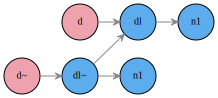

((-1000001, -1), (1000022,), (1000022,), (-1000001, -1))


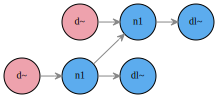

((-1000001, -1), (1000022,), (1000022,), (1000001, 1))


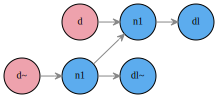

((1000001, 1), (1000022,), (1000022,), (1000001, 1))


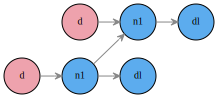

In [18]:
for key,process in ttt_t.items():
    print(key)
    print_diagram(process)

In [19]:
def generate_xsecs(model):
    fsts = []
    for xsec in model.xsections:
        fsts.append(xsec.pid)
    return fsts

Cross Section: (2212, 2212) -> (1000022, 1000022)


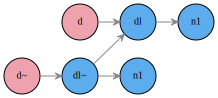

In [20]:
xsecs = generate_xsecs(model)
dgms = {}
for xsec in xsecs:
    dgms[xsec] = []
    for process in tto.keys():
        if sorted(list(xsec)) == sorted(list(process[-1])):
            dgms[xsec].append(tto[process])
    for process in ttt_s.keys():
        if sorted(list(xsec)) == sorted(list(process[-1])):
            dgms[xsec].append(ttt_s[process])
    for process in ttt_t.keys():
        sort_xsec = sorted(list(xsec))
        sort_fst = sorted([process[0][0],process[-1][0]])
        if sort_xsec == sort_fst:
            dgms[xsec].append(ttt_t[process])

#print(dgms)
for xsec in model.xsections:
    print("Cross Section:",xsec.full_pid[0:2],"->",xsec.pid)
    for process in dgms[xsec.pid]:
        print_diagram(process)